# Import Necessary Libraries

In [58]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Data Collection

In [102]:
# Step 1: Data Loading
dataset_path = r"C:\Users\SunawarKhan\JupyterNotebook\HeartDiseaseDetection\mitbih_database"

def load_single_file(file_path):
    ecg_data = pd.read_csv(file_path + ".csv")
    ecg_data.columns = ecg_data.columns.str.strip().str.replace("'", "")
    annotations = pd.read_csv(file_path + "annotations.txt", sep='\t')
    annotations.columns = annotations.columns.str.strip().str.replace("'", "")
    return ecg_data, annotations

first_file = os.path.join(dataset_path, "100")
ecg_data, annotations = load_single_file(first_file)
print("Columns in the ECG data:", ecg_data.columns.tolist())
print("Columns in the annotations data:", annotations.columns.tolist())

ecg_data_list = []
annotations_list = []
for file in os.listdir(dataset_path):
    if file.endswith(".csv"):
        base_filename = os.path.splitext(file)[0]
        ecg_data, annotations = load_single_file(os.path.join(dataset_path, base_filename))
        ecg_data_list.append(ecg_data)
        annotations_list.append(annotations)

print("Step 1: Data Loaded")
print(f"Number of ECG files loaded: {len(ecg_data_list)}")
print(f"Number of annotation files loaded: {len(annotations_list)}")
print(ecg_data_list[0].head())
print(annotations_list[0].head())

Columns in the ECG data: ['sample #', 'MLII', 'V5']
Columns in the annotations data: ['Time   Sample #  Type  Sub Chan  Num', 'Aux']
Step 1: Data Loaded
Number of ECG files loaded: 48
Number of annotation files loaded: 48
   sample #  MLII    V5
0         0   995  1011
1         1   995  1011
2         2   995  1011
3         3   995  1011
4         4   995  1011
         Time   Sample #  Type  Sub Chan  Num  Aux
0      0:00.050       18     +    0    0    0   (N
1      0:00.214       77     N    0    0    0  NaN
2      0:01.028      370     N    0    0    0  NaN
3      0:01.839      662     N    0    0    0  NaN
4      0:02.628      946     N    0    0    0  NaN


# Step 2: Data Preprocessing

In [103]:
# Step 2: Data Preprocessing with Missing Data Handling
def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=360, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def handle_missing_data(ecg_data, signal_column):
    if ecg_data[signal_column].isnull().any():
        median_value = ecg_data[signal_column].median()
        ecg_data[signal_column].fillna(median_value, inplace=True)
    return ecg_data

def preprocess_ecg(ecg_data, signal_column):
    if signal_column not in ecg_data.columns:
        raise KeyError(f"Column '{signal_column}' not found in the data. Available columns: {ecg_data.columns.tolist()}")
    ecg_data = handle_missing_data(ecg_data, signal_column)
    ecg_data[signal_column] = normalize_signal(ecg_data[signal_column])
    ecg_data[signal_column] = bandpass_filter(ecg_data[signal_column])
    return ecg_data

def get_signal_column(ecg_data):
    for col in ['MLII', 'V1', 'V5', 'V2']:
        if col in ecg_data.columns:
            return col
    raise KeyError(f"No valid signal column found in the data. Available columns: {ecg_data.columns.tolist()}")

preprocessed_ecg_list = []
for ecg_data in ecg_data_list:
    try:
        signal_column = get_signal_column(ecg_data)
        print(f"Using signal column: {signal_column}")
        preprocessed_ecg_list.append(preprocess_ecg(ecg_data, signal_column))
    except KeyError as e:
        print(e)

print("Step 2: Data Preprocessed")
print(preprocessed_ecg_list[0].head())

Using signal column: MLII
Using signal column: MLII
Using signal column: V5
Using signal column: MLII
Using signal column: V5
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal column: MLII
Using signal col

# Step 3: Data Segmentation

Number of segment groups: 48
Number of label groups: 48
Number of non-empty segment groups: 48
Number of non-empty label groups: 48
Step 3: Data Segmented
Total number of segments: 112647
Total number of labels: 112647


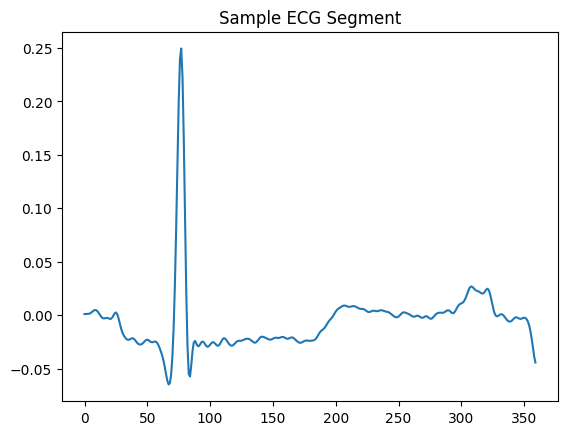

X (segments) dtype: float64
y (labels) dtype: object
First few y (labels): ['    0:00.050       18     +    0    0    0'
 '    0:00.214       77     N    0    0    0'
 '    0:01.028      370     N    0    0    0'
 '    0:01.839      662     N    0    0    0'
 '    0:02.628      946     N    0    0    0'
 '    0:03.419     1231     N    0    0    0'
 '    0:04.208     1515     N    0    0    0'
 '    0:05.025     1809     N    0    0    0'
 '    0:05.678     2044     A    0    0    0'
 '    0:06.672     2402     N    0    0    0']
Total number of segments after cleaning: 0
Total number of labels after cleaning: 0
Unique labels in y: []


In [107]:
# Step 3: Data Segmentation with Correct Alignment and Data Cleaning
def segment_ecg(signal, window_size=360, step_size=180):
    segments = []
    for start in range(0, len(signal) - window_size, step_size):
        end = start + window_size
        segment = signal[start:end]
        segments.append(segment)
    return np.array(segments)

all_segments = []
segment_labels = []
for ecg_data, annotations in zip(preprocessed_ecg_list, annotations_list):
    signal_column = get_signal_column(ecg_data)
    segments = segment_ecg(ecg_data[signal_column].values)
    all_segments.append(segments)
    
    # Align annotations with segments
    annotation_column = 'Type'
    if annotation_column not in annotations.columns:
        annotation_column = [col for col in annotations.columns if 'Type' in col][0]

    num_segments = len(segments)
    labels = annotations[annotation_column].values[:num_segments]
    segment_labels.append(labels)

# Debug: Print lengths of segments and labels before concatenation
print(f"Number of segment groups: {len(all_segments)}")
print(f"Number of label groups: {len(segment_labels)}")

# Ensure that all segment and label groups have data
all_segments = [seg for seg in all_segments if len(seg) > 0]
segment_labels = [lbl for lbl in segment_labels if len(lbl) > 0]

# Debug: Print lengths after filtering
print(f"Number of non-empty segment groups: {len(all_segments)}")
print(f"Number of non-empty label groups: {len(segment_labels)}")

all_segments = np.concatenate(all_segments, axis=0)
segment_labels = np.concatenate(segment_labels, axis=0)

# Ensure that the number of segments matches the number of labels
min_len = min(len(all_segments), len(segment_labels))
all_segments = all_segments[:min_len]
segment_labels = segment_labels[:min_len]

print("Step 3: Data Segmented")
print("Total number of segments:", len(all_segments))
print("Total number of labels:", len(segment_labels))

plt.plot(all_segments[0])
plt.title('Sample ECG Segment')
plt.show()

# Verify data types and contents
print("X (segments) dtype:", all_segments.dtype)
print("y (labels) dtype:", segment_labels.dtype)
print("First few y (labels):", segment_labels[:10])

# Ensure all labels are numeric
segment_labels = pd.to_numeric(segment_labels, errors='coerce')
segment_labels = segment_labels[~np.isnan(segment_labels)].astype(int)

# Ensure all segments are of correct shape
all_segments = all_segments[:len(segment_labels)]

print("Total number of segments after cleaning:", len(all_segments))
print("Total number of labels after cleaning:", len(segment_labels))

# Debug: Check if there are any remaining non-numeric values in y
print("Unique labels in y:", np.unique(segment_labels))

# Step 4: Model Design - Classical CNN

In [108]:
# Step 4: Model Design - Classical CNN
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (all_segments.shape[1], 1)
model = create_cnn_model(input_shape)
print("Step 4: Model Created")
model.summary()

Step 4: Model Created
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 358, 32)           128       
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 179, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_25 (Conv1D)          (None, 177, 64)           6208      
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 88, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 5632)              0         
                                                                 
 dense_24 (Dense)            (N

# Step 5: Training and Validation - Classical CNN

In [ ]:
# Step 5: Training and Validation - Classical CNN
# Reshape segments for the CNN model
X = all_segments.reshape((all_segments.shape[0], all_segments.shape[1], 1))
y = segment_labels

# Check if there are enough samples
if len(X) == 0 or len(y) == 0:
    raise ValueError("No samples available for training and validation.")

# Ensure all data in X and y are numeric
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

# Check for any remaining non-numeric values in y
if not np.issubdtype(y.dtype, np.integer):
    raise ValueError(f"Non-numeric values found in y: {y}")

# Print shapes of X and y to debug
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
print("Step 5: Model Trained")
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history)

# Step 6: Evaluation and Results - Classical CNN

In [ ]:
# Step 6: Evaluation and Results - Classical CNN
y_pred = model.predict(X_val).argmax(axis=1)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print("Step 6: Model Evaluation")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Step 7: Quantum Classifier Design

In [ ]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer

# Define quantum device
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

# Quantum circuit ansatz
def quantum_circuit(weights, x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Quantum node
weight_shapes = {"weights": (3, n_qubits, 3)}
qml_circuit = qml.QNode(quantum_circuit, dev, interface="tf")

# Quantum classifier model
def quantum_model(weights, x):
    return qml_circuit(weights, x)

# Define hybrid quantum-classical model
class QuantumNN(tf.keras.Model):
    def __init__(self):
        super(QuantumNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(8)
        self.dense2 = tf.keras.layers.Dense(4)
        self.quantum_layer = qml.qnn.KerasLayer(qml_circuit, weight_shapes, output_dim=n_qubits)
        self.dense3 = tf.keras.layers.Dense(2, activation='softmax')
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.quantum_layer(x)
        return self.dense3(x)

# Create quantum-classical hybrid model
quantum_model = QuantumNN()
quantum_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Step 7: Quantum Model Created")
quantum_model.summary()


# Step 8: Training and Validation of Quantum Classifier

In [ ]:
# Train the quantum model
quantum_history = quantum_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
print("Step 8: Quantum Model Trained")
print("Quantum Training Accuracy:", quantum_history.history['accuracy'][-1])
print("Quantum Validation Accuracy:", quantum_history.history['val_accuracy'][-1])

# Step 9: Evaluation of Quantum Classifier

In [ ]:
# Evaluate the quantum model
quantum_y_pred = quantum_model.predict(X_val).argmax(axis=1)
quantum_conf_matrix = confusion_matrix(y_val, quantum_y_pred)
quantum_class_report = classification_report(y_val, quantum_y_pred)

print("Step 9: Quantum Model Evaluation")
print("Quantum Confusion Matrix:\n", quantum_conf_matrix)
print("Quantum Classification Report:\n", quantum_class_report)
